<a href="https://colab.research.google.com/github/KillerStrike17/Learn_With_Shubham/blob/master/Talks/Interpreting%20the%20Network%20Results/Attention%20Maps/Learn_WIth_Shubham_Attention_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Feb 27 05:01:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    26W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Importing Libraries




In [2]:

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
import scipy
import os
import matplotlib.pyplot as plt
import numpy as np

In [9]:
dir(scipy.ndimage.interpolation)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_nd_image',
 '_ni_support',
 'absolute_import',
 'affine_transform',
 'division',
 'doccer',
 'docdict_copy',
 'docfiller',
 'geometric_transform',
 'itertools',
 'map_coordinates',
 'numpy',
 'print_function',
 'rotate',
 'shift',
 'spline_filter',
 'spline_filter1d',
 'warnings',
 'zoom']

### Loading Model

In [3]:
model = VGG16(weights="imagenet")
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

### GradCAM


In [0]:
def grad_cam(input_model, image, layer_name,H=224,W=224):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    #grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    #print (cam)

    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = scipy.ndimage.interpolation.zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

### GradCAM ++

In [0]:
def grad_cam_plus(input_model, img, layer_name,H=224,W=224):
    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    #cost = 全部のラベルの値。cost*label_indexでy_cになる
    conv_output = input_model.get_layer(layer_name).output
    #conv_output = target_conv_layer, mixed10の出力1,5,5,2048
    grads = K.gradients(y_c, conv_output)[0]
    #grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    #print deep_linearization_weights
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    # Passing through ReLU
    cam = np.maximum(grad_CAM_map, 0)
    cam = scipy.ndimage.interpolation.zoom(cam,H/cam.shape[0])
    cam = cam / np.max(cam) # scale 0 to 1.0    
    #cam = resize(cam, (224,224))

    return cam

image/cat_dog.png
class activation map for: ('n02108089', 'boxer', 0.42014146)


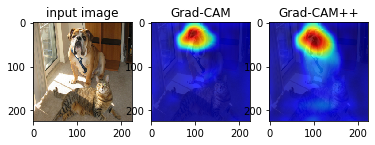

image/collies.jpg
class activation map for: ('n02106166', 'Border_collie', 0.67478734)


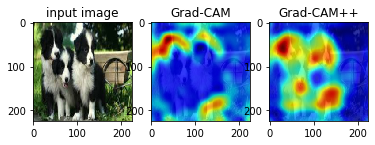

image/water-bird.jpg
class activation map for: ('n02006656', 'spoonbill', 0.9999374)


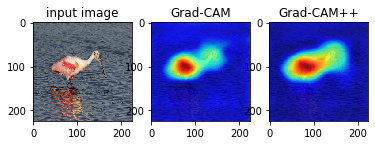

image/tony_stark.jpg
class activation map for: ('n04356056', 'sunglasses', 0.33366606)


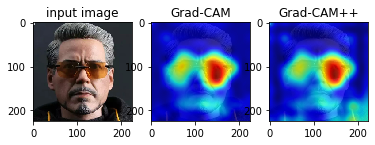

In [16]:
paths = ["cat_dog.png","collies.jpg","water-bird.jpg","tony_stark.jpg"]
# paths = ["cat_dog.png"]""
for path in paths:
    path = os.path.join("assets",path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = model.predict(img)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    cls = np.argsort(predictions[0])[-top_n:][::-1]
    
    gradcam=grad_cam(model,img,layer_name='block5_conv3')
    gradcamplus=grad_cam_plus(model,img,layer_name='block5_conv3')
    print(path)
    print("class activation map for:",top[0])
    fig, ax = plt.subplots(nrows=1,ncols=3)
    plt.subplot(131)
    plt.imshow(orig_img)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM")
    plt.subplot(133)
    plt.imshow(orig_img)
    plt.imshow(gradcamplus,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM++")
    plt.show()